# Emotion Classification with Llama 3 Instruct 8B

In [1]:
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.models import Llama3
from lib.dataset_utils import Llama_EmotionsData
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

/home/g.demarco5/group_21/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Loading Twitter

In [2]:
twitter_train, _, twitter_test = load_twitter_data_cleaned() 
twitter_emotions = ('joy', 'sadness','anger', 'fear', 'love', 'surprise')
twitter_test_dataset = Llama_EmotionsData(twitter_test)

2000
2000


### Loading Goemotions

In [3]:
label_mapping_path = "./dataset/GoEmotionsSplit/label_mapping.json"
goemotions_train, _, goemotions_test = load_goemotions_cleaned()
goemotions_test_dataset = Llama_EmotionsData(goemotions_test)
json1_file = open(label_mapping_path)
json1_str = json1_file.read()
json1_data = json.loads(json1_str)
goemotions_emotions = str(json1_data.values())

5427
5427


In [4]:
def accuracy(targets, predictions):
    return accuracy_score(targets, predictions)
def jaccard(targets, predictions):
    return jaccard_score(targets, predictions, average='micro', zero_division=0)
def jaccard_samples(targets, predictions):
    return jaccard_score(targets, predictions, average='samples', zero_division=0)
def f1(targets, predictions):
    return f1_score(targets, predictions, average='macro', zero_division=0)
def f1_micro(targets, predictions):
    return f1_score(targets, predictions, average='micro', zero_division=0)

SCORES = {"accuracy": accuracy, "jaccard": jaccard, "jaccard_samples":jaccard_samples, "f1": f1, "f1_micro": f1_micro}
 
# 3 Shots from Twitter training set
TWITTER_SAMPLES = f"""Look at these examples:\n
Sentence: i think it s the easiest time of year to feel dissatisfied\n
Answer: anger\n
Sentence: i feel as confused about life as a teenager or as jaded as a year old man\n
Answer: fear\n
Sentence: i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies\n
Answer: surprise\n
Now """ # ..."Classify the sentence" etc.

# 3 Shots from Goemotions training set
GOEMOTIONS_SAMPLES = f"""Look at these examples:\n
Sentence: Slowing things down now\n
\nDoes it evoke the emotion 'disappointment'?
Answer: False\n
Sentence: Aww... she'll probably come around eventually, I'm sure she was just jealous of [NAME]... I mean, what woman wouldn't be! lol \n
\nDoes it evoke the emotion 'amusement'?
Answer: True\n
Sentence: Super, thanks\n
\nDoes it evoke the emotion 'gratitude'?
Answer: True\n 
Now """ # ..."Consider the following sentence" etc.

# Twitter 0 Shots

/home/g.demarco5/group_21/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2000


  0%|          | 0/2000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         joy       0.16      0.45      0.24       275
     sadness       0.17      0.12      0.14       224
       anger       0.40      0.03      0.05       695
        fear       0.05      0.03      0.04       159
        love       0.38      0.40      0.39       581
    surprise       0.11      0.56      0.19        66

   micro avg       0.22      0.22      0.22      2000
   macro avg       0.21      0.27      0.18      2000
weighted avg       0.30      0.22      0.19      2000
 samples avg       0.22      0.22      0.22      2000



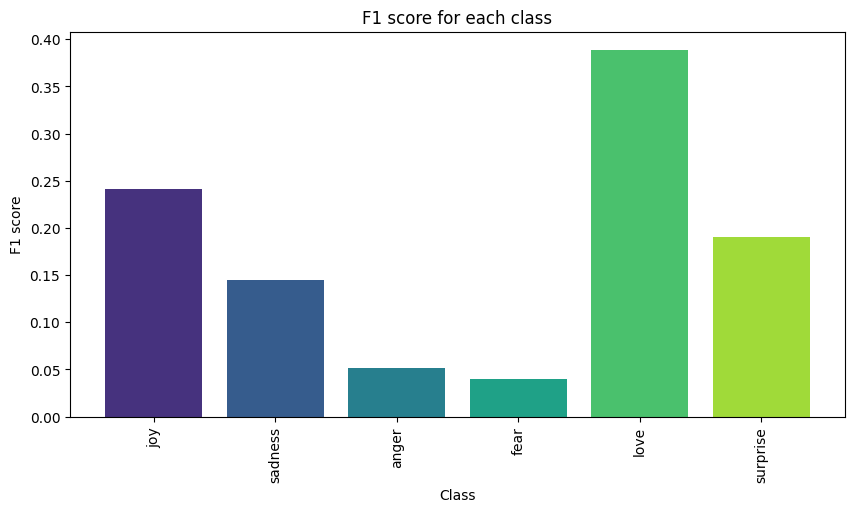

In [5]:
twitter_0shot_llama3 = Llama3(model_name, scores = SCORES, emotions=twitter_emotions)
results = twitter_0shot_llama3.classify(twitter_test_dataset, progress_bar = True)
del twitter_0shot_llama3

# Twitter 3 Shots

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/2000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         joy       0.16      0.43      0.23       275
     sadness       0.10      0.08      0.09       224
       anger       0.59      0.05      0.09       695
        fear       0.06      0.04      0.05       159
        love       0.36      0.38      0.37       581
    surprise       0.11      0.58      0.19        66

   micro avg       0.22      0.22      0.22      2000
   macro avg       0.23      0.26      0.17      2000
weighted avg       0.35      0.22      0.19      2000
 samples avg       0.22      0.22      0.22      2000



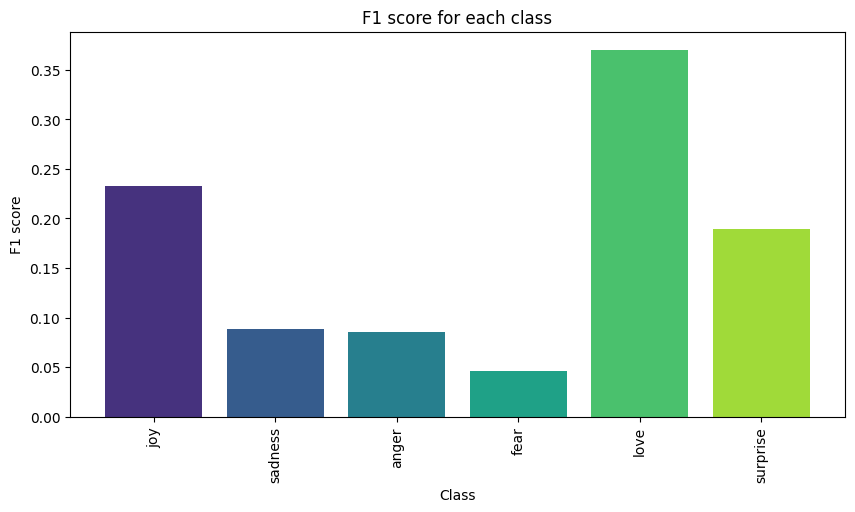

In [7]:
twitter_3shot_llama3 = Llama3(model_name, scores = SCORES, emotions=twitter_emotions, samples = TWITTER_SAMPLES)
results = twitter_3shot_llama3.classify(twitter_test_dataset, progress_bar = True)
del twitter_3shot_llama3

In [16]:
del goemo_0shot_llama3
del twitter_3shot_llama3
del twitter_0shot_llama3
del goemo_3shot_llama3

NameError: name 'goemo_0shot_llama3' is not defined

# Goemotions 0 Shots

In [ ]:
goemo_0shot_llama3 = Llama3(model_name, scores = SCORES, emotions=twitter_emotions, mode ="multi")
results = goemo_0shot_llama3.classify(goemotions_test_dataset, progress_bar = True)
del goemo_0shot_llama3


/home/g.demarco5/group_21/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/g.demarco5/group_21/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/g.demarco5/group_21/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/5427 [00:00<?, ?it/s]

# Goemotions 3 Shots

In [10]:
goemo_3shot_llama3 = Llama3(model_name, scores = SCORES, emotions=twitter_emotions, mode = "multi")
results = goemo_3shot_llama3.classify(goemotions_test_dataset, progress_bar = True, samples = GOEMOTIONS_SAMPLES)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


NameError: name 'twitter_3shot_llama3' is not defined